# A Closer Look at Model-Based Policy Gradients

---
## Linear Quadratic Gaussian (LQG) Problems
In what follows we consider MDPs with:
1. continuous state space $\mathbf{s} \in \mathcal{S} = \mathbb{R}^n$
2. continuous action space $\mathbf{a} \in \mathcal{A} = \mathbb{R}^d$
3. finite time horizon $N \in \mathbb{N}$ and timesteps $t \in \mathcal{T} = \{0, \dots, N - 1\}$
4. time-varying linear Gaussian dynamics 
    $$
    \mathbf{s}_{t+1} \sim p(\cdot| \mathbf{s}_t, \mathbf{a}_t) = \mathcal{N}\left( \cdot ~\middle|~ \mathbf{F}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} + \mathbf{f}_t, \mathbf{\Sigma}_{t} \right)
    $$
5. time-varying quadratic costs 
    $$
    r_{t+1} = R(\mathbf{s}_t, \mathbf{a}_t) = - \tfrac{1}{2} \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}^\intercal \mathbf{C}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} - \mathbf{c}_t^\intercal \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}
    $$
6. Gaussian-distributed initial state 
    $$
    \mathbf{s}_0 \sim \rho = \mathcal{N}(\mathbf{\mu}_\rho, \mathbf{\Sigma}_\rho)
    $$

### Imports

In [1]:
from __future__ import annotations

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from gym.spaces import Box
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ortho_group
from torch import Tensor
from tqdm.auto import tqdm

import lqsvg.torch.named as nt
from lqsvg.envs import lqr
from lqsvg.envs.lqr.gym import LQGGenerator

sns.set()

### Environment generation

In what follows we consider **time-invaryant dynamics**: ($\mathbf{F}_t, \mathbf{f}_t, \mathbf{\Sigma}_t = \mathbf{F}, \mathbf{f}, \mathbf{\Sigma}, \forall t\in\mathcal{T}$.

In [2]:
generator = LQGGenerator(n_state=2, n_ctrl=2, horizon=100, seed=0, stationary=True)

In [3]:
with nt.suppress_named_tensor_warning():
    dynamics, cost, init = generator(n_batch=None)

print(f"""
Dynamics:
    F: {dynamics.F.shape}, {dynamics.F.names}
    f: {dynamics.f.shape}, {dynamics.f.names}
    W: {dynamics.W.shape}, {dynamics.W.names}

Cost:
    C: {cost.C.shape}, {cost.C.names}
    c: {cost.c.shape}, {cost.c.names}
    
Initial state:
    mean: {init.mu.shape}, {init.mu.names}
    covariance: {init.sig.shape}, {init.sig.names}
""")


Dynamics:
    F: torch.Size([100, 2, 4]), ('H', 'R', 'C')
    f: torch.Size([100, 2]), ('H', 'R')
    W: torch.Size([100, 2, 2]), ('H', 'R', 'C')

Cost:
    C: torch.Size([100, 4, 4]), ('H', 'R', 'C')
    c: torch.Size([100, 4]), ('H', 'R')
    
Initial state:
    mean: torch.Size([2]), ('R',)
    covariance: torch.Size([2, 2]), ('R', 'C')



### Stability of the un-actuated system

Suppose we run the system with 0 inputs for an indefinite amount of time. Will the values of $\mathbf{s}_t$ diverge? We test for this by checking that the eigenvalues $\{\lambda_i \}_{i=1}^{n}$ of $\mathbf{F_s}$, where $\mathbf{F} = [\mathbf{F_s\ F_a}]$, are all within the unit circle in the complex plane.

![](images/stable_eigvals.png)

In [4]:
def isstationary(dynamics: lqr.LinSDynamics) -> bool:
    return nt.allclose(dynamics.F, dynamics.F.select("H", 0))

def stat_dynamics_factors(dynamics: lqr.LinSDynamics) -> tuple[Tensor, Tensor]:
    assert isstationary(dynamics)
    _, n_ctrl, _ = lqr.dims_from_dynamics(dynamics)
    F_s, F_a = dynamics.F[0, :, :-n_ctrl], dynamics.F[0, :, -n_ctrl:]  # assume stationary and no batch
    return F_s, F_a

In [5]:
def trans_kernel_eigvals(dynamics: lqr.LinSDynamics) -> Tensor:
    F_s, _ = stat_dynamics_factors(dynamics)
    eigvals, _ = torch.eig(nt.unnamed(F_s))
    return eigvals

def isstable(dynamics: lqr.LinSDynamics, verbose: bool = False) -> bool:
    eigvals = trans_kernel_eigvals(dynamics)
    if verbose:
        print(eigvals)
    return torch.all(torch.norm(eigvals, dim=-1) <= 1.0).item()

In [6]:
isstable(dynamics, verbose=True)

tensor([[-0.0473,  0.0000],
        [ 0.5346,  0.0000]])


True

Let's see if we spot any trends when generating transition dynamics by sampling the entries in $\mathbf{F}$ independently from a standard Normal distribution. ($\mathcal{N}(0, 1)$)

In [7]:
import lqsvg.envs.lqr.generators as gens

def standard_normal_dynamics(gen: LQGGenerator) -> lqr.LinSDynamics:
    dynamics = gens.make_linsdynamics(gen.n_state, gen.n_ctrl, gen.horizon, stationary=True)
    F_s, F_a = stat_dynamics_factors(dynamics)
    F = torch.cat([torch.randn_like(F_s), F_a], dim=-1).expand_as(dynamics.F)
    return lqr.LinSDynamics(F=F.refine_names(*dynamics.F.names), f=dynamics.f, W=dynamics.W)

def gen_std_normal_dynamics(gen: LQGGenerator, samples: int):
    return (standard_normal_dynamics(gen) for _ in range(samples))

In [8]:
stable = [isstable(g, verbose=True) for g in gen_std_normal_dynamics(generator, 10)]
print(stable)

tensor([[-2.3321,  0.0000],
        [ 0.2865,  0.0000]])
tensor([[0.1203, 0.0000],
        [1.1893, 0.0000]])
tensor([[ 0.2624,  0.0000],
        [-1.0048,  0.0000]])
tensor([[1.2604, 0.0000],
        [0.1425, 0.0000]])
tensor([[ 0.5583,  0.0000],
        [-0.6879,  0.0000]])
tensor([[-0.3671,  0.0000],
        [ 0.8844,  0.0000]])
tensor([[ 0.5114,  0.0000],
        [-0.4032,  0.0000]])
tensor([[-1.2209,  0.0000],
        [-0.4706,  0.0000]])
tensor([[0.6680, 0.0000],
        [1.2890, 0.0000]])
tensor([[-0.0474,  0.0000],
        [-1.8137,  0.0000]])
[False, False, False, False, True, True, True, False, False, False]


We see that a lot of the dynamics generated are unstable. Let's plot a histogram of stable vs. unstable systems.

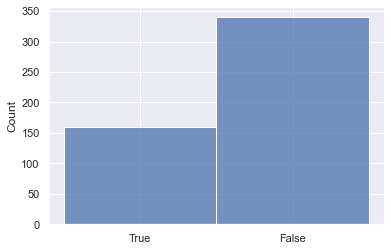

In [9]:
sns.histplot(data=list(map(str, map(isstable, gen_std_normal_dynamics(generator, 500)))))
plt.show()

We quickly see that a majority of systems generated this way are unstable. We may then see how unstable by plotting a histogram of the magnitude of the largest eigenvalue.

In [10]:
def max_eigval_norm(dynamics: lqr.LinSDynamics) -> float:
    eigvals = trans_kernel_eigvals(dynamics)
    return torch.max(torch.norm(eigvals, dim=-1)).item()

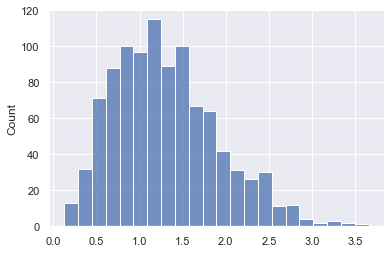

In [11]:
sns.histplot(data=list(map(max_eigval_norm, gen_std_normal_dynamics(generator, 1000))))
plt.show()

We can see that a lot of the generated matrices have eigenvalues with norms well above 1.

Let's also check if the trends observed above generalize to different state sizes.

In [20]:
def hist_by_state_dim(func: callable, sampler, **kwargs):
    fig, axes = plt.subplots(1, 8, figsize=[4 * 6.4, 4.8])

    for i, ax in tqdm(enumerate(axes), total=8):
        generator.n_state = 2 * (i + 1)

        data = list(map(func, (sampler(generator) for _ in range(1000))))
        if all(isinstance(d, bool) for d in data):
            data = list(map(str, data))
            kwargs.update(shrink=.8, stat="probability", bins=["True", "False"])

        sns.histplot(
            ax=ax, 
            data=data,
            **kwargs
        )
        ax.set_title(f"State size: {generator.n_state}")

    plt.tight_layout()
    plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

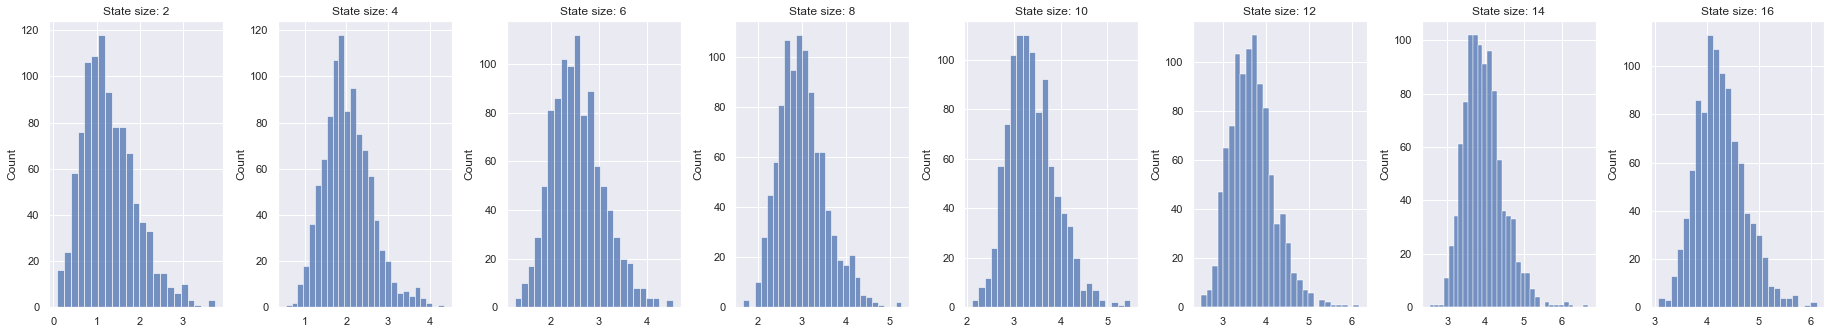

In [17]:
hist_by_state_dim(max_eigval_norm, standard_normal_dynamics)

In [18]:
def all_real_eigval(dynamics: lqr.LinSDynamics) -> bool:
    eigval = trans_kernel_eigvals(dynamics)
    return torch.allclose(eigval[..., -1], torch.zeros_like(eigval[..., -1]))

  0%|          | 0/8 [00:00<?, ?it/s]

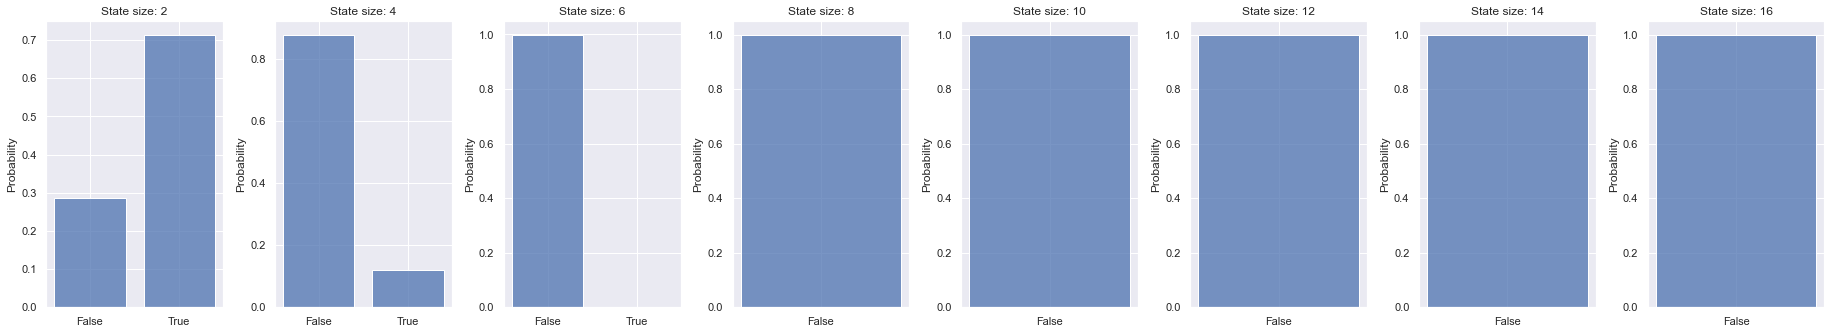

In [21]:
hist_by_state_dim(all_real_eigval, standard_normal_dynamics)

### Generating stable dynamics

To have stable dynamics we generate random matrices $\mathbf{F_s}$ with eigenvalues with absolute values less or equal to 1. We start by sampling each eigenvalue independently from the uniform distribution $\mathcal{U}(-1, 1)$. Then we use the trick described in the blog post [Generate a random matrix with specified eigenvalues](https://blogs.sas.com/content/iml/2012/03/30/geneate-a-random-matrix-with-specified-eigenvalues.html) to generate a random matrix with the sampled eigenvalues.

<div class="alert alert-block alert-info">
    <b>Note:</b> for now we sample only real eigenvalues
</div>

In [22]:
def stable_dynamics(gen: LQGGenerator) -> lqr.LinSDynamics:
    dynamics = gens.make_linsdynamics(gen.n_state, gen.n_ctrl, gen.horizon, stationary=True)
    F_s, F_a = stat_dynamics_factors(dynamics)
    
#     eigvals, _ = torch.eig(nt.unnamed(F_s))
#     F_s = F_s / torch.norm(eigvals, dim=-1).max()
    
    ortho = torch.as_tensor(ortho_group.rvs(gen.n_state), dtype=torch.float)
    eigvals = torch.diag_embed(torch.empty(gen.n_state).uniform_(-1, 1))
    F_s = ortho.transpose(-2, -1) @ eigvals @ ortho
    
    F = torch.cat([F_s, F_a], dim=-1).expand_as(dynamics.F)
    return lqr.LinSDynamics(F=F.refine_names(*dynamics.F.names), f=dynamics.f, W=dynamics.W)

def gen_stable_dynamics(gen: LQGGenerator, samples: int):
    return (stable_dynamics(gen) for _ in range(samples))

  0%|          | 0/8 [00:00<?, ?it/s]

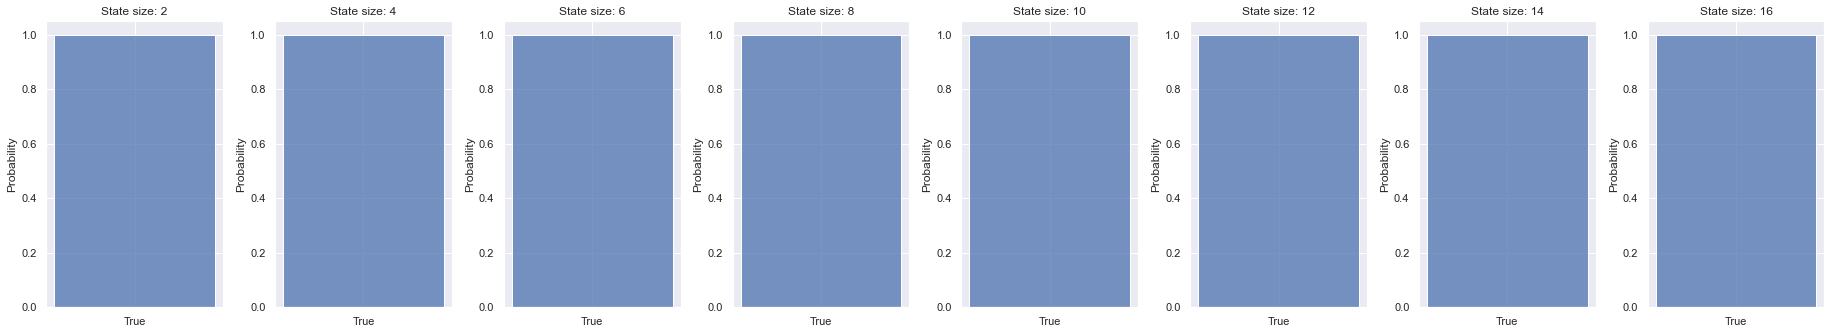

In [23]:
hist_by_state_dim(isstable, stable_dynamics)

  0%|          | 0/8 [00:00<?, ?it/s]

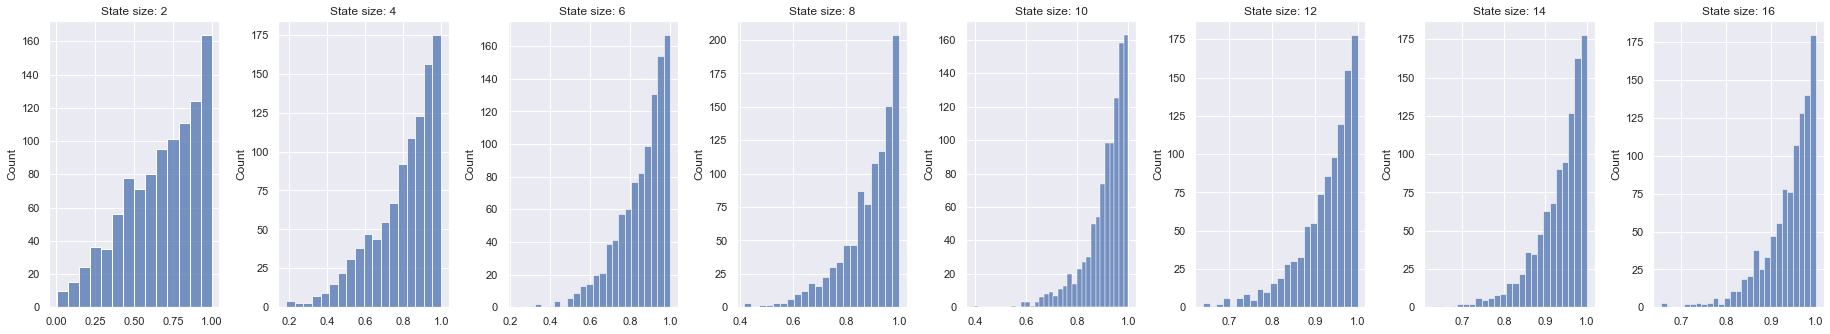

In [24]:
hist_by_state_dim(max_eigval_norm, stable_dynamics)

  0%|          | 0/8 [00:00<?, ?it/s]

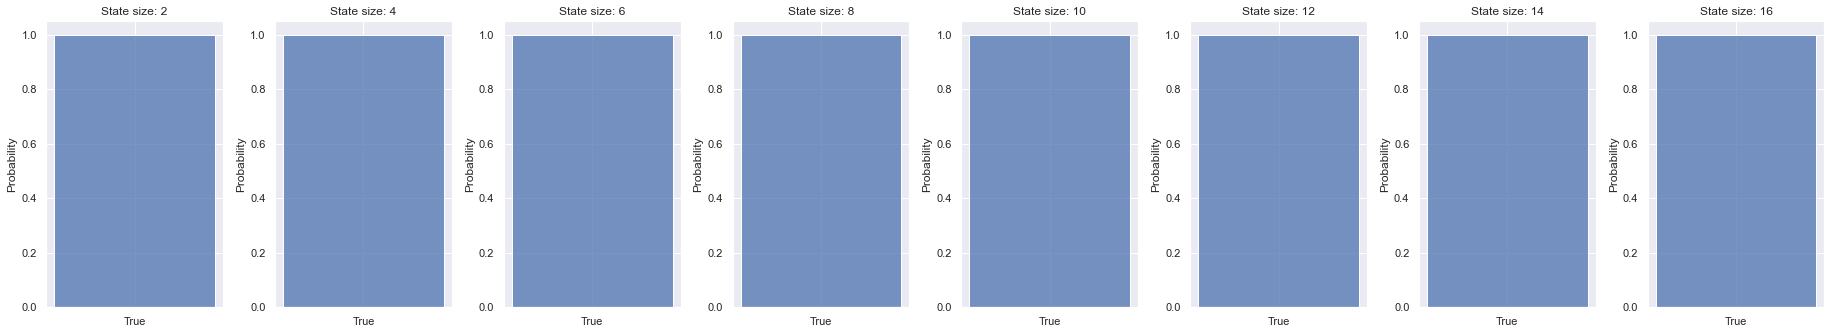

In [25]:
hist_by_state_dim(all_real_eigval, stable_dynamics)

In [26]:
def issymmetric(dynamics: lqr.LinSDynamics) -> bool:
    F_s, _ = stat_dynamics_factors(dynamics)
    return nt.allclose(F_s, nt.transpose(F_s))

  0%|          | 0/8 [00:00<?, ?it/s]

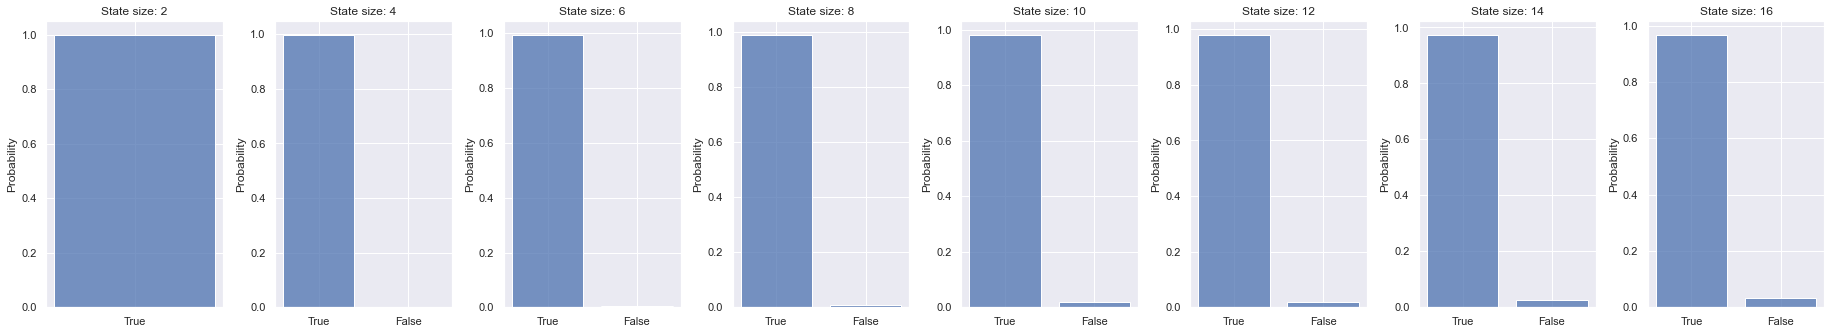

In [27]:
hist_by_state_dim(issymmetric, stable_dynamics)

### Testing controllability

Next, we build the **controllability matrix** for randomly generated systems and visualize the distribution of the controllability status.

In [28]:
def ctrb(dynamics: lqr.LinSDynamics) -> Tensor:
    F_s, F_a = stat_dynamics_factors(dynamics)
    n_state, _, _ = lqr.dims_from_dynamics(dynamics)
    return torch.cat([torch.matrix_power(F_s, i) @ F_a for i in range(n_state)], dim=-1)

In [29]:
def iscontrollable(dynamics: lqr.LinSDynamics) -> bool:
    n_state, _, _ = lqr.dims_from_dynamics(dynamics)
    C = ctrb(dynamics)
    return (torch.matrix_rank(nt.unnamed(C)) == n_state).item()

  0%|          | 0/8 [00:00<?, ?it/s]

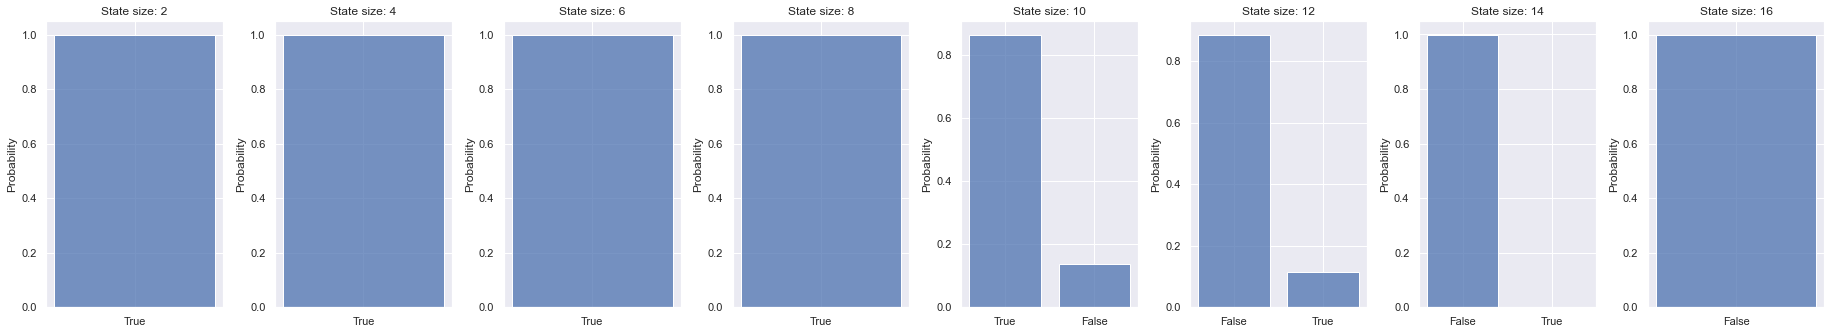

In [30]:
hist_by_state_dim(iscontrollable, standard_normal_dynamics)

  0%|          | 0/8 [00:00<?, ?it/s]

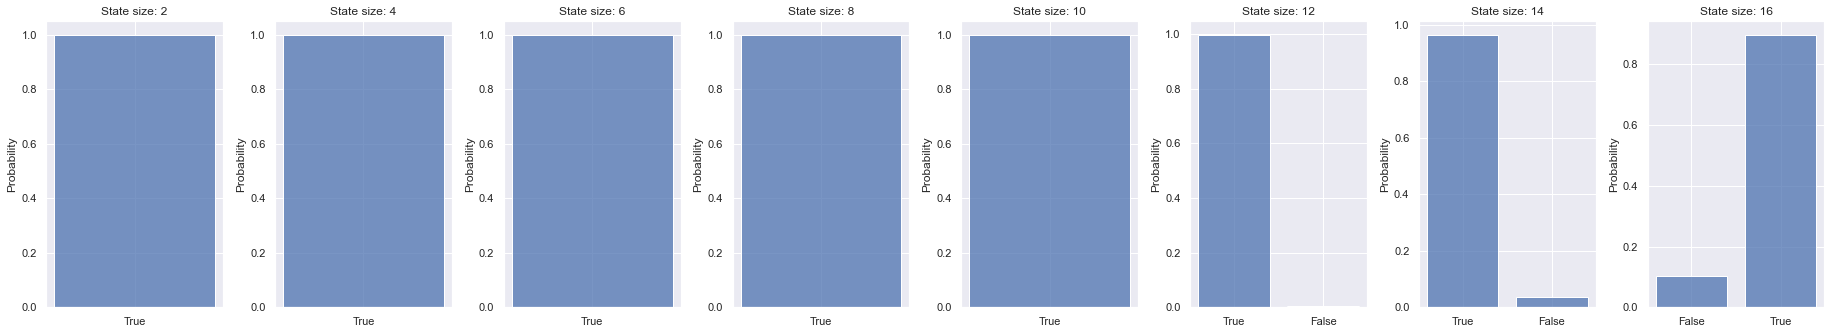

In [31]:
hist_by_state_dim(iscontrollable, stable_dynamics)

We see that for both standard normal and stable dynamics generators the resulting systems are mostly uncontrollable as the state size increases.

Let's try to generate stable, controllable systems by exploiting the consequences of the Popov-Belevitch-Hautus (PBH) test.

In [32]:
def stable_ctrb_dynamics(gen: LQGGenerator) -> lqr.LinSDynamics:
    ### Copied from stable_dynamics ###
    dynamics = gens.make_linsdynamics(gen.n_state, gen.n_ctrl, gen.horizon, stationary=True)
    _, F_a = stat_dynamics_factors(dynamics)
    
    ortho = torch.as_tensor(ortho_group.rvs(gen.n_state), dtype=torch.float)
    eigvals = torch.diag_embed(torch.empty(gen.n_state).uniform_(-1, 1))
    F_s = ortho.transpose(-2, -1) @ eigvals @ ortho
    ### ###
    
    F_a_eig = F_a.clone().uniform_(0.9, 1.1)
    F_a = ortho @ F_a_eig
    
    F = torch.cat([F_s, F_a], dim=-1).expand_as(dynamics.F)
    return lqr.LinSDynamics(F=F.refine_names(*dynamics.F.names), f=dynamics.f, W=dynamics.W)

  0%|          | 0/8 [00:00<?, ?it/s]

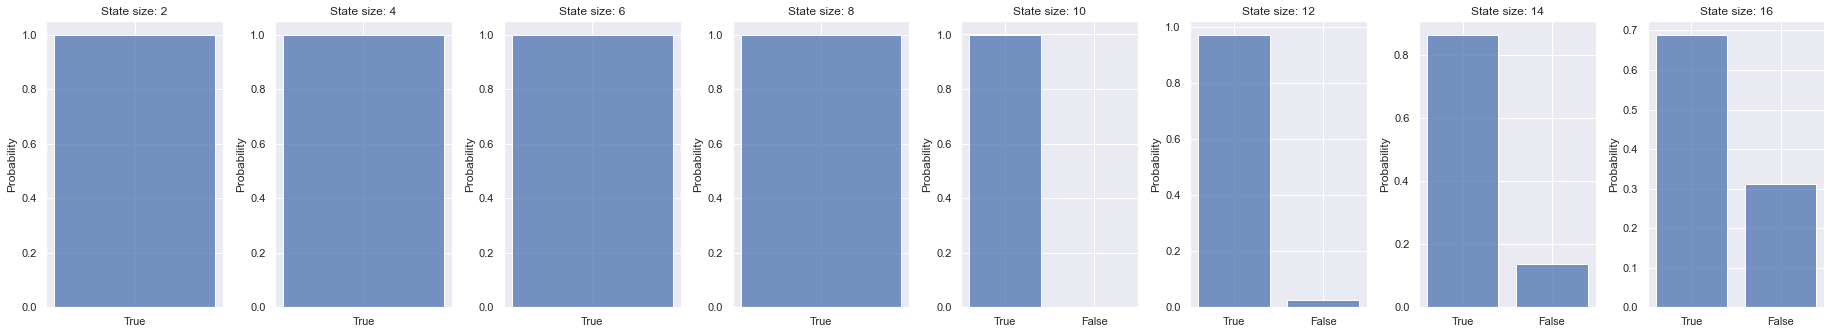

In [33]:
hist_by_state_dim(iscontrollable, stable_ctrb_dynamics)

## Time-varying linear policy

A time-varying linear policy is a mapping $\mu_\theta: \mathcal{S}\times\mathcal{T} \mapsto \mathcal{A}$ such that
$$
    \mu_\theta(\mathbf{s}, t) = \mathbf{K}_t \mathbf{s} + \mathbf{k}_t
    \,,
$$
where $\mathbf{K}_t \in \mathbb{R}^{d\times n}$, $\mathbf{k}_t \in \mathbb{R}^d$ and $\theta = \{\mathbf{K}_t, \mathbf{k}_t\}_{t\in\mathcal{T}}$.

In [ ]:
from lqsvg.policy.time_varying_linear import TVLinearFeedback

## Quadratic State-value

$$
        V^\mu(\mathbf{s}, t) = {\tfrac12} \mathbf{s}^\intercal\mathbf{V}_t\mathbf{s} + \mathbf{v}_t^\intercal\mathbf{s} + v_t, \quad t\in\mathcal{T}^+ \,,
$$

In [ ]:
from typing import Optional

class ValueFn(nn.Module):
    def __init__(self, quadratic: lqr.Quadratic, timestep: int = 0):
        super().__init__()
        V, v, c = (x.select("H", timestep) for x in quadratic)
        self.register_buffer("V", V.align_to("R", "C"))
        self.register_buffer("v", v.align_to("R", "C"))
        self.register_buffer("c", c.align_to("R", "C"))
        assert len(self.V.shape) == len(self.v.shape) == len(self.c.shape) == 2, \
            (self.V.shape, self.v.shape, self.c.shape)
        
    def symeig(self) -> Tensor:
        return torch.symeig(self.V.rename(None))

    def forward(self, state: Tensor):
        """Calculate optimal state-value.

        May be used with batched states.
        """
        s = nt.vector_to_matrix(state)
        value = nt.transpose(s) @ self.V @ s / 2 \
                + nt.transpose(self.v) @ s \
                + self.c
        return nt.matrix_to_scalar(value)
    
    def min(self):
        Vinv = nt.unnamed(self.V).inverse()
        return nt.matrix_to_vector(-Vinv @ self.v)
    
    def expected(self, init: lqr.GaussInit):
        """Expected cost given mean and covariance matrix of the initial state.
        
        https://en.wikipedia.org/wiki/Quadratic_form_(statistics)#Expectation.
        """
        mean = nt.vector_to_matrix(init.mu)
        cov = init.sig
        value = nt.scalar_to_matrix(nt.trace(cov @ self.V)) / 2 \
            + nt.transpose(mean) @ self.V @ mean \
            + nt.transpose(self.v) @ mean \
            + self.c
        return nt.matrix_to_scalar(value)
            
    def plot_3d(self, ax, mean: Optional[Tensor] = None, amp: float = 10):
        if mean is None:
            mean = self.min().detach().numpy()
        else:
            mean = mean.detach().numpy()

        xrange = np.linspace(mean[0] -amp, mean[0] + amp, num=100)
        yrange = np.linspace(mean[1] -amp, mean[1] + amp, num=100)
        xbatch, ybatch = np.meshgrid(xrange, yrange)
        assert xbatch.shape == ybatch.shape == (100, 100)

        init_states = np.stack([xbatch, ybatch], axis=-1).reshape((-1, 2))
        init_states = torch.from_numpy(init_states).float().refine_names("B", "R")
        assert init_states.shape == (10000, 2), init_states.shape

        init_values = self(init_states).detach().numpy()
        assert init_values.shape == (10000,), init_values.shape

        init_values = init_values.reshape(xbatch.shape)
        ax.plot_surface(xbatch, ybatch, init_values, cmap=cm.coolwarm)
        
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("value")

# Exact methods
---
## LQG control

<img src="images/LQG - Control.png" width=800>

In [ ]:
def print_solution(policy, qval, vval):
    K, k = policy
    Q, q, qc = qval
    V, v, vc = vval
    
    print(f"""
    Policy:
        K: {K.shape}, {K.names}
        k: {k.shape}, {k.names}
    """)
    
    print(f"""
    Q-value:
        Q: {Q.shape}, {Q.names}
        q: {q.shape}, {q.names}
        const: {qc.shape}, {qc.names}
    """)

    print(f"""
    V-value:
        V: {V.shape}, {V.names}
        V: {v.shape}, {v.names}
        const: {vc.shape}, {vc.names}
    """)

In [ ]:
lqg_control = lqr.NamedLQGControl(n_state, n_ctrl, horizon)
pistar, qstar, vstar = lqg_control(dynamics, cost)
print_solution(pistar, qstar, vstar)

In [ ]:
vstar_fn = ValueFn(vstar)
print(vstar_fn.V)
print(vstar_fn.v)
print(vstar_fn.c)

### Optimal value for best initial state
$$
\begin{align}
\mathbf{s}_{min} 
&= \arg\min_{\mathbf{s}} V^\star(\mathbf{s}, 0) \\
&= \arg\min_{\mathbf{s}} \mathbf{s}^\intercal \mathbf{V}_0^\star \mathbf{s} + {\mathbf{v}_0^\star}^\intercal \mathbf{s} + v_0^\star \\
&= -{\mathbf{V}_0^\star}^{-1} \mathbf{v}_0^\star \\
\end{align}
$$

In [ ]:
minimum = vstar_fn.min()
print(f"""
    Best initial state: {minimum}
    Best initial value: {vstar_fn(minimum)}
""")

### Optimal expected initial state value
$$
\mathbb{E}_{\mathbf{s}\sim\rho} \left[ V^{\star}(\mathbf{s}, 0) \right]
= \text{Tr}(\mathbf{V}_0\mathbf{\Sigma}_0) + \mathbf{\mu}_0^\intercal \mathbf{V}_0 \mathbf{\mu}_0 + \mathbf{v}_0^\intercal \mathbf{\mu}_0 + v_0
$$

In [ ]:
print(f"""
    Mean: {init.mu}
    Covariance: {init.sig}
    Expected value: {vstar_fn.expected(init)}
""")

### Optimal value for each initial state

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
vstar_fn.plot_3d(ax, mean=init.mu)
# plt.savefig("navigation2d_value.png")
plt.show()

In [ ]:
print(vstar_fn.symeig())

## LQG prediction (Policy Evaluation)

<img src="images/LQG - Prediction.png" width=800>

In [ ]:
lqg_prediction = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)

## Perturbed optimal policies

We generate sub-optimal policies by adding uniform noise to the optimal policy's parameters, i.e., 
$$
    \mathbf{K}_t = \mathbf{K}_t^\star + \epsilon, \qquad \epsilon \sim \mathcal{U}(\mathbf{0}, \mathbf{0.5}) \\
    \mathbf{k}_t = \mathbf{k}_t^\star + \epsilon, \qquad \epsilon \sim \mathcal{U}(\mathbf{0}, \mathbf{0.5})
$$

In [ ]:
def rand_policy(policy, seed):
    K, k = policy
    torch.manual_seed(seed)
    K = K + torch.rand_like(K) * 0.5
    k = k + torch.rand_like(k) * 0.5
    return (K, k)

In [ ]:
policy = rand_policy(pistar, seed=seed)

_, vval = lqg_prediction(policy, dynamics, cost)
vval_fn = ValueFn(vval)
min_state = vval_fn.min()
print(f"""
    V: {vval_fn.V}
    v: {vval_fn.v}
    c: {vval_fn.c}
    
    min state: {min_state}
    min value: {vval_fn(min_state)}
""")

In [ ]:
fig = plt.figure(figsize=(8, 16))
ax = fig.add_subplot(1, 2, 1, projection="3d")
vval_fn.plot_3d(ax, mean=init.mu)
ax.set_title("Perturbed")

ax = fig.add_subplot(1, 2, 2, projection="3d")
vstar_fn.plot_3d(ax, mean=init.mu)
ax.set_title("Optimal")

# plt.savefig("navigation2d_value.png")
plt.show()

In [ ]:
print(vval_fn.symeig())
print(vstar_fn.symeig())

## Policy learning via true value gradients

LQG prediction can be seen as a function mapping policy parameters (with the dynamics kept constant) to value function coefficients:
$$
\left( \mathbf{Q}, \mathbf{q}, q, \mathbf{V}, \mathbf{v}, v \right) = \text{LQGPrediction}(\theta)
$$

Thus, we can write each coeficient as a function of policy parameters. For example, the value function for a policy $\mu_\theta$ would be:
$$
V^\mu(\mathbf{s}, t) = \tfrac12 \mathbf{s}^\intercal \mathbf{V}_t(\theta) \mathbf{s} + \mathbf{v}_t(\theta)^\intercal \mathbf{s} + v_t(\theta)
$$

We can then express policy performance as a direct function of policy parameters:
$$
\begin{align}
J(\theta) 
    &= \mathbb{E}_{\mathbf{s}\sim\rho} \left[ \tfrac12 \mathbf{s}^\intercal \mathbf{V}_0(\theta) \mathbf{s} + \mathbf{v}_0(\theta)^\intercal \mathbf{s} + v_0(\theta) \right] \\
    &= \text{Tr}(\mathbf{V}_0(\theta)\mathbf{\Sigma}_0) + \mathbf{\mu}_0^\intercal \mathbf{V}_0(\theta) \mathbf{\mu}_0 + \mathbf{v}_0(\theta)^\intercal \mathbf{\mu}_0 + v_0(\theta)
\end{align}
$$

In [ ]:
class TVLFLoss(nn.Module):
    def __init__(
        self, 
        dynamics: lqr.LinDynamics,
        cost: lqr.QuadCost,
        init: lqr.GaussInit,
    ):
        super().__init__()
        n_state = dynamics.F.size("R")
        n_ctrl = dynamics.F.size("C") - n_state
        horizon = dynamics.F.size("H")
        self.predict = lqr.NamedLQGPrediction(n_state, n_ctrl, horizon)
        self.dynamics = dynamics
        self.cost = cost
        self.init = init
        
    def forward(self, policy: lqr.Linear):
        _, vval = self.predict(policy, self.dynamics, self.cost)
        vval_fn = ValueFn(vval)
        cost = vval_fn.expected(self.init)
        return cost

In [ ]:
loss_fn = TVLFLoss(dynamics, cost, init)
loss = loss_fn(policy)
print("Random policy loss:", loss)

Finally, since the value function coefficients are differentiable functions of the policy parameters, we can optimize the latter for better performance via gradient ascent
$$
\theta \gets \theta + \alpha \nabla_{\theta} J(\theta)
$$

In [ ]:
tvlp = TVLinearFeedback.from_existing(policy)
optim = torch.optim.Adam(tvlp.parameters(), lr=1e-3)

for i in range(100):
# for i in range(1):
    for p in tvlp.parameters():
        p.grad = None
    loss = loss_fn(tvlp.gains())
    loss.backward()
    optim.step()
    if i % 100 == 0:
        print("Loss:", loss.item())
print("Loss:", loss_fn(tvlp.gains()).item())
print("Best possible:", vstar_fn.expected(loss_fn.init).item())

In [ ]:
learned_vval = ValueFn(lqg_prediction(tvlp.gains(), dynamics, cost)[1])
fig = plt.figure(figsize=(8, 16))

ax = fig.add_subplot(1, 2, 1, projection="3d")
vstar_fn.plot_3d(ax, mean=init.mu)
ax.set_title("Optimal")

ax = fig.add_subplot(1, 2, 2, projection="3d")
learned_vval.plot_3d(ax, mean=init.mu)
ax.set_title("Learned")

plt.show()